In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import importlib
import utils
import attention
import glob
from collections import defaultdict

import seaborn as sns
import pandas as pd

# Number of Parameters in Each Model

In [25]:

outdir = "/scratch/gpfs/qanguyen/renorm"
arches = ["mlp", "cnn", "cnn_chan_1-16", "cnn_chan_1-1", "alexnet", "vgg11", "attn", "attn_no_pe"]
for arch in arches:
    for f in glob.glob(f"{outdir}/{arch}_shuffled_True*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        shapes = [v.ravel().shape for p, v in record["model"]]
        print(arch, torch.sum(torch.tensor(shapes)))

mlp tensor(328510)
cnn tensor(62006)
cnn_chan_1-16 tensor(59626)
cnn_chan_1-1 tensor(14236)
alexnet tensor(57044810)
vgg11 tensor(128807306)
attn tensor(8458250)
attn_no_pe tensor(8458250)


# Train & Test Loss, Accuracy

Number of runs alexnet True 1
Number of runs alexnet False 1
[3.21698040263668] 1
[1.8926814430078882] 1


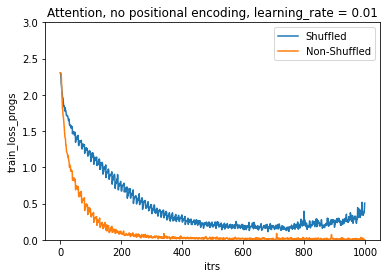

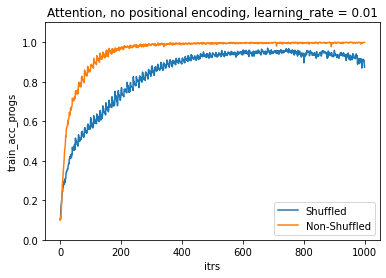

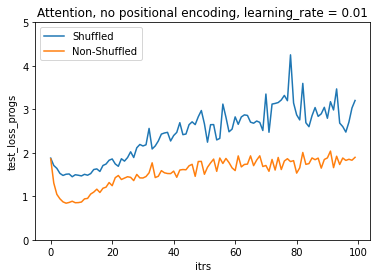

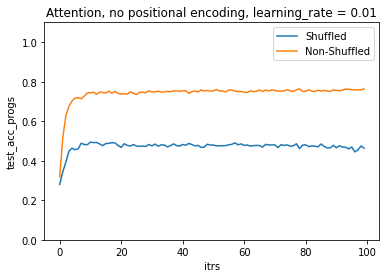

model_True_test_losses [3.21698040263668]
model_False_test_losses [1.8926814430078882]


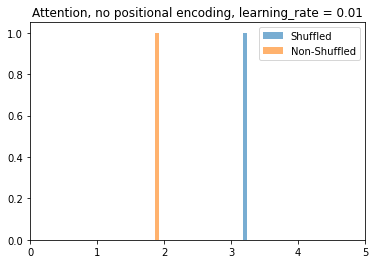

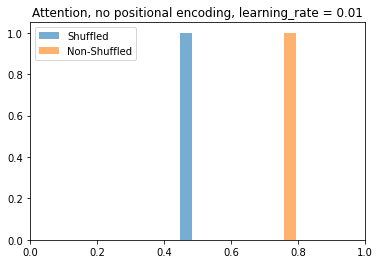

In [2]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    test_losses = []
    test_accs = []
    lrs = []
    itrs = []
    train_loss_progs = []
    train_acc_progs = []
    testlosses_dict = []
    
    test_itrs = []
    test_loss_progs = []
    test_acc_progs = []
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        itr, train_loss_prog = list(zip(*enumerate(record["metrics"]["train_loss_prog"])))
        if len(itr) > 500:
            test_losses.append(record["metrics"]["test_loss"])
            test_accs.append(record["metrics"]["test_accuracy"])
            itrs.extend(itr)
            train_loss_progs.extend(train_loss_prog)
            testlosses_dict.extend([record["metrics"]["test_loss"]] * len(itr))
            
        itr, train_acc_prog = list(zip(*enumerate(record["metrics"]["train_acc_prog"])))
        if len(itr) > 500:
            train_acc_progs.extend(train_acc_prog)
            
        itr, test_loss_prog = list(zip(*enumerate(record["metrics"]["test_loss_prog"])))
        test_itrs.extend(itr)
        test_loss_progs.extend(test_loss_prog)
        
        itr, test_acc_prog = list(zip(*enumerate(record["metrics"]["test_acc_prog"])))
        test_acc_progs.extend(test_acc_prog)
        
    print("Number of runs", model_name, shuffled, len(test_losses))
    train_df = pd.DataFrame.from_dict(dict(itrs = itrs, 
                                                         train_loss_progs = train_loss_progs, 
                                                         train_acc_progs = train_acc_progs,
                                                         testlosses_dict = testlosses_dict))
    test_df = pd.DataFrame.from_dict(dict(itrs = test_itrs, 
                                                         test_loss_progs = test_loss_progs, 
                                                         test_acc_progs = test_acc_progs))
    return test_losses, test_accs, lrs, train_df, test_df
    
    
def plot(model_name, title, extra=""):
    model_True_test_losses, model_True_test_accs, _, shuffletrainloss, shuffletestloss  = get_record(model_name = model_name, shuffled = "True", extra = extra)
    model_False_test_losses, model_False_test_accs, _, non_shuffletrainloss, non_shuffletestloss = get_record(model_name = model_name, shuffled = "False", extra = extra)
    model_True_test_losses = [i for i in model_True_test_losses if not np.isnan(i)]
    
    #model_True_test_losses = [i for i in model_True_test_losses if i < np.sort(model_True_test_losses)[-1]]
    #model_False_test_losses = [i for i in model_False_test_losses if i < np.sort(model_False_test_losses)[-1]]
    print(model_True_test_losses, len(model_True_test_losses))
    print(model_False_test_losses, len(model_False_test_losses))

    sns.lineplot(x = "itrs", y="train_loss_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_loss_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 3)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="train_acc_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_acc_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
                                     
    sns.lineplot(x = "itrs", y="test_loss_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_loss_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="test_acc_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_acc_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
    
    print("model_True_test_losses", model_True_test_losses)
    print("model_False_test_losses", model_False_test_losses)
    plt.hist(model_True_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 5)
    plt.title(title)
    plt.legend()
    plt.show()
    

    plt.hist(model_True_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 1)
    plt.title(title)
    plt.legend()
    plt.show()

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

plot("alexnet", title = "Attention, no positional encoding, learning_rate = 0.01", extra="lr_0.01")

# plot("vgg11", title = "VGG, learning_rate = 0.001", extra="lr_0.001")

# plot("vgg11", title = "VGG, learning_rate = 0.01", extra="lr_0.01")

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

# plot("attn_no_pe", title = "Attention, no positional encoding")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels")

# plot("mlp", title = "MLP", extra="lr_0.001")

# plot("mlp", title = "MLP", extra="lr_0.01")


## Holding the shuffle permutation fixed

[[[0.4496173  0.52663434 0.47668734]
  [0.54987353 0.55575544 0.5160403 ]
  [0.49554032 0.5608506  0.5492583 ]
  [0.5134214  0.52657974 0.4315286 ]
  [0.43549526 0.510604   0.5265976 ]
  [0.55574983 0.48856792 0.45850074]
  [0.5135425  0.48764232 0.46054152]
  [0.46217045 0.52114636 0.46102372]
  [0.5325329  0.5497944  0.5467843 ]
  [0.5329117  0.5293136  0.46599266]
  [0.504152   0.5038543  0.47570086]]

 [[0.5091302  0.50606674 0.55340743]
  [0.5502989  0.5440201  0.5395487 ]
  [0.53897417 0.5202846  0.4036138 ]
  [0.5355207  0.44556168 0.5176998 ]
  [0.48846766 0.5544489  0.5427135 ]
  [0.5677274  0.53840053 0.47507572]
  [0.45627674 0.4762116  0.4716182 ]
  [0.47201705 0.46289653 0.49129343]
  [0.54394644 0.5046541  0.46903798]
  [0.5069712  0.5397295  0.5476844 ]
  [0.49559498 0.5559115  0.5402565 ]]

 [[0.5109227  0.5133579  0.49632737]
  [0.481006   0.4987156  0.5582062 ]
  [0.5232589  0.5462615  0.4835016 ]
  [0.41105163 0.46870846 0.48534986]
  [0.5309055  0.5225289  0.5383739

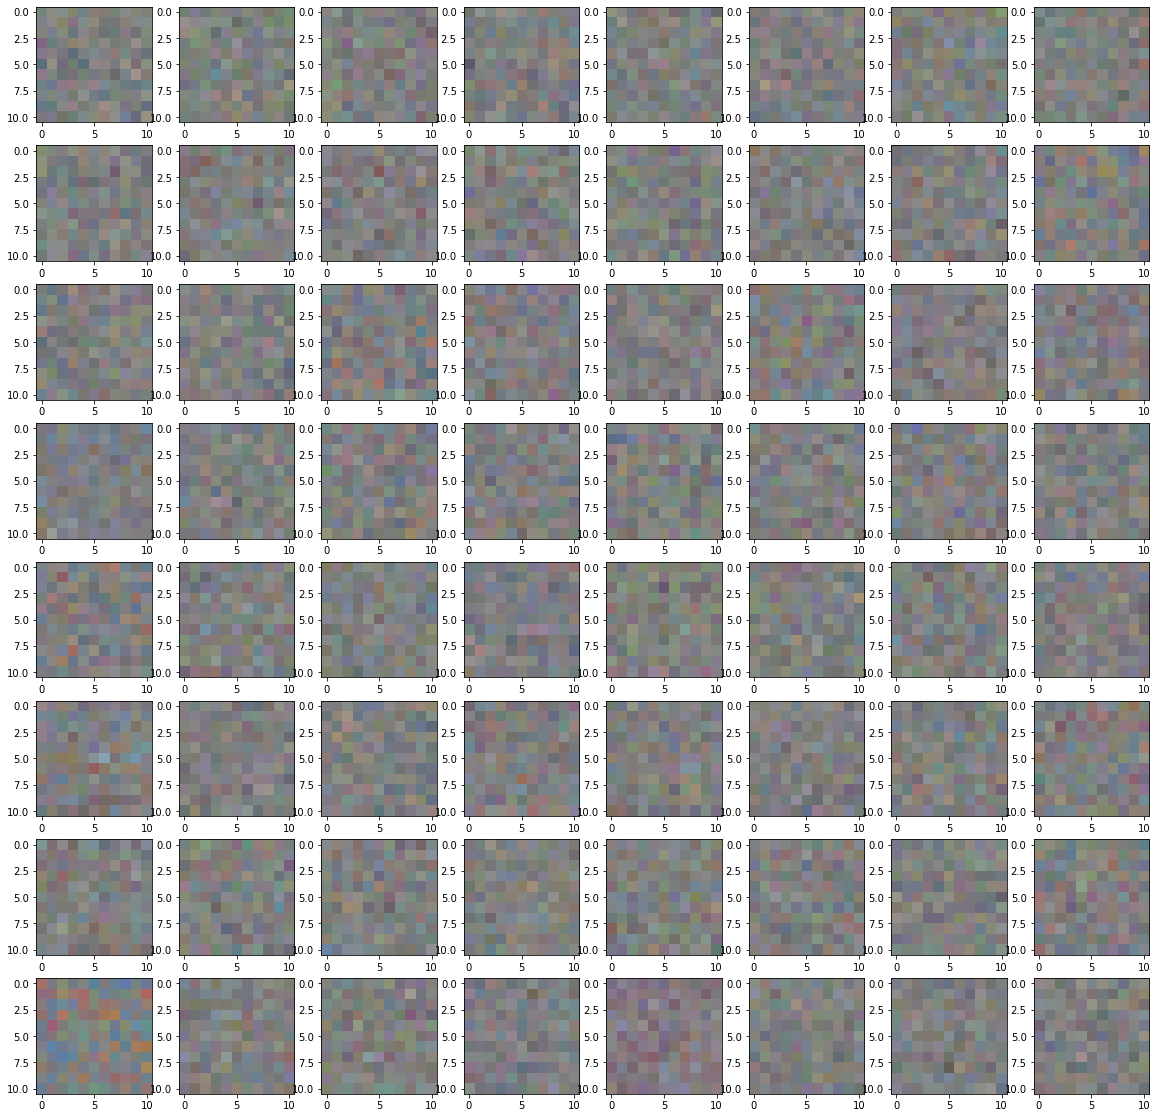

NameError: name 'model' is not defined

In [16]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:2]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            if _ == 0:
                print(v)
            plt.imshow(v)
            #pars[_].append(v)
        plt.show()
        
        print(model)
        break
get_record("alexnet", shuffled=True)

# Average the filters for different quenched transformations 


In [ ]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}
        param_dict['conv1.weight'] = param_dict['conv1.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        #plt.figure(figsize=(10,5))
        for _ in range(6):
            #plt.subplot(1, 6, _+1)
            v = param_dict['conv1.weight'][_].detach().cpu().numpy()
            #plt.imshow(v)
            pars[_].append(v)
        #print(param_dict['conv1.weight'])
        #plt.show()
    plt.figure(figsize=(10,5))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(1, 6, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds)
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "cnn", shuffled=True)
get_record(model_name = "cnn", shuffled=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

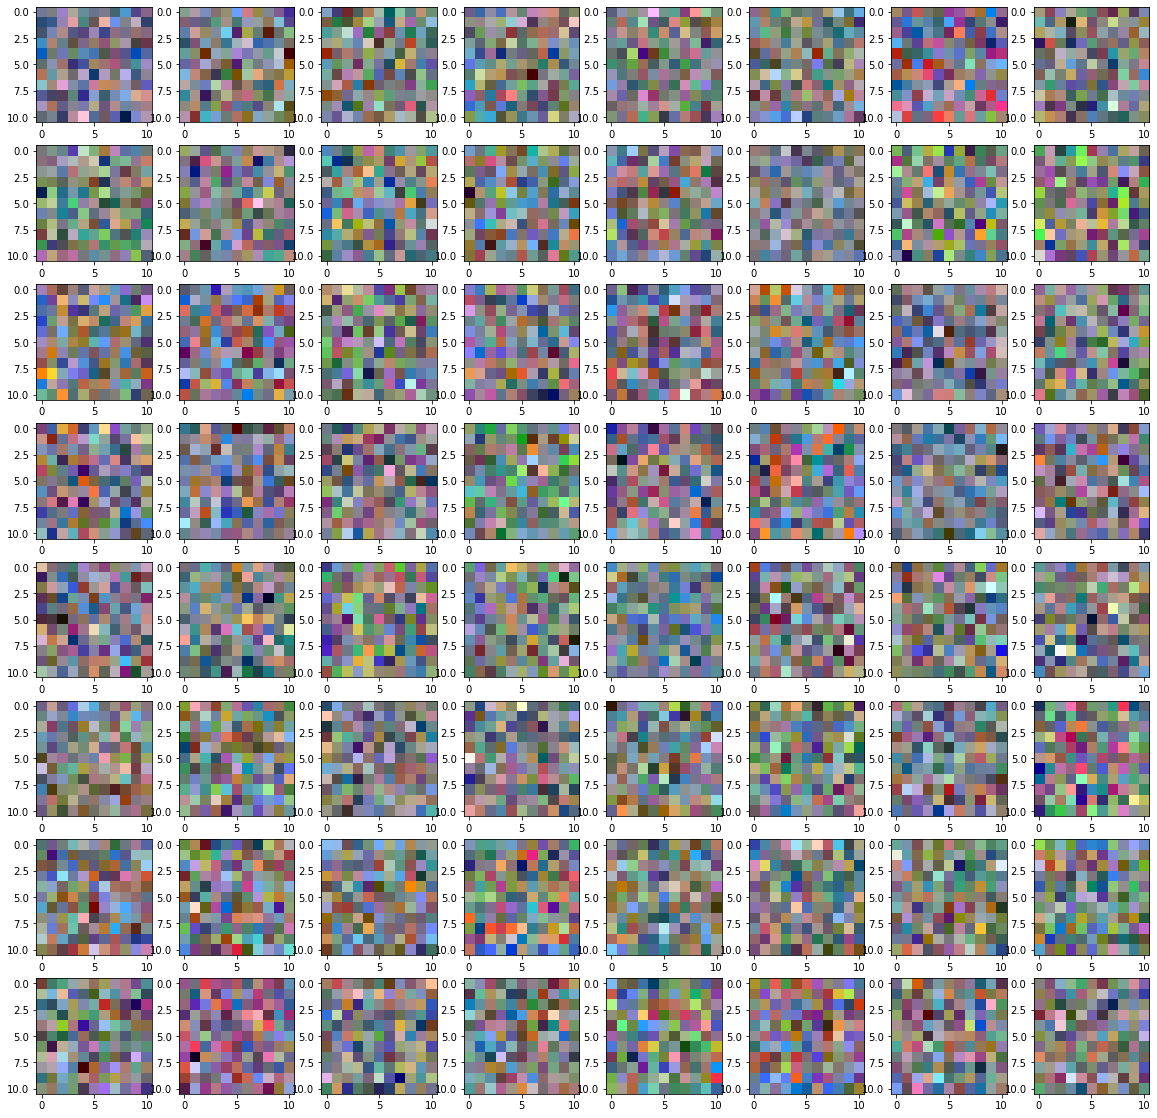

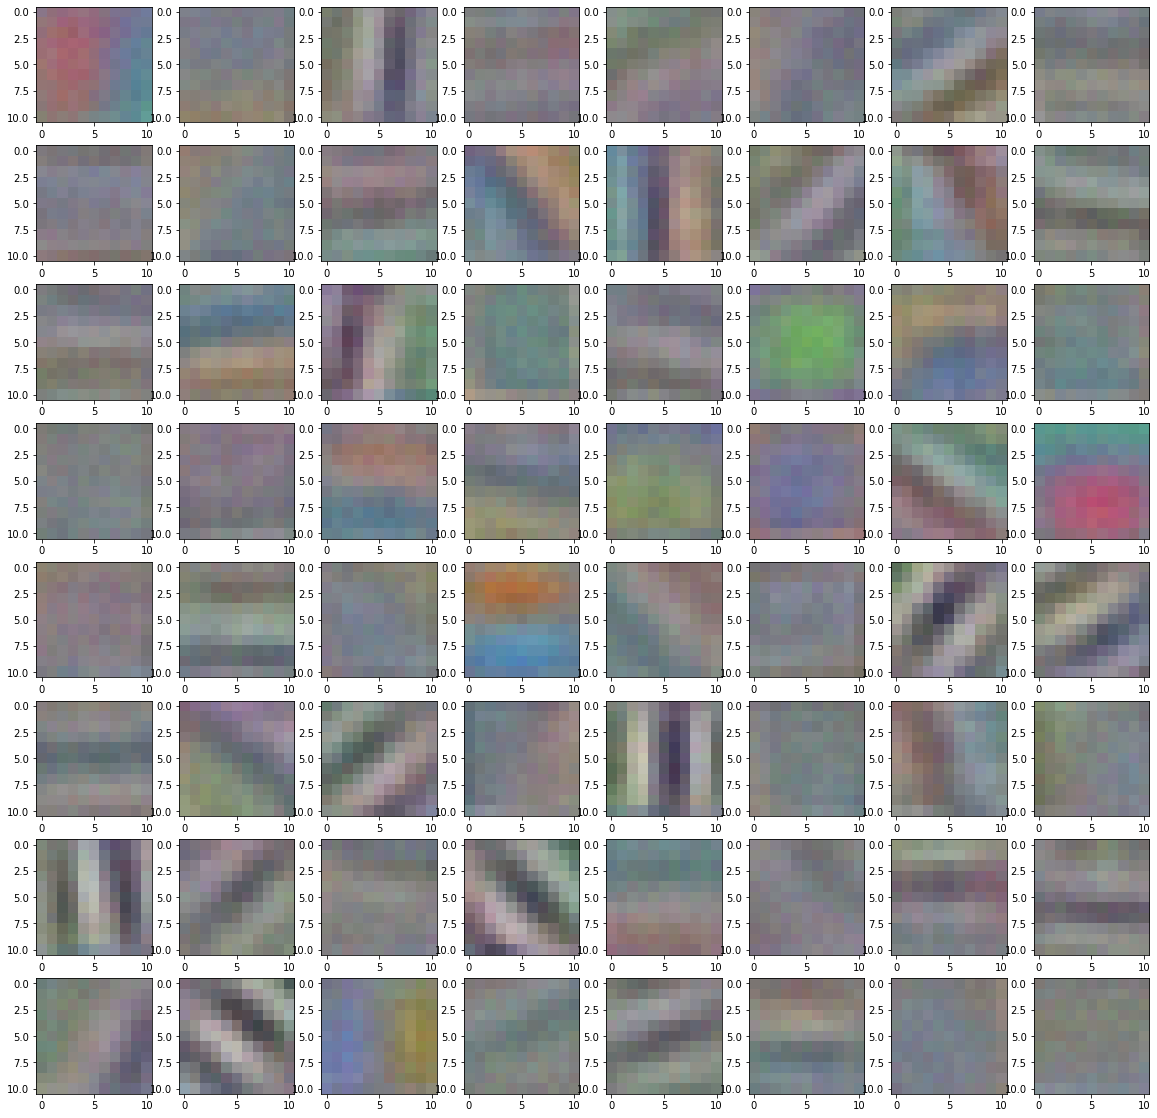

In [66]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

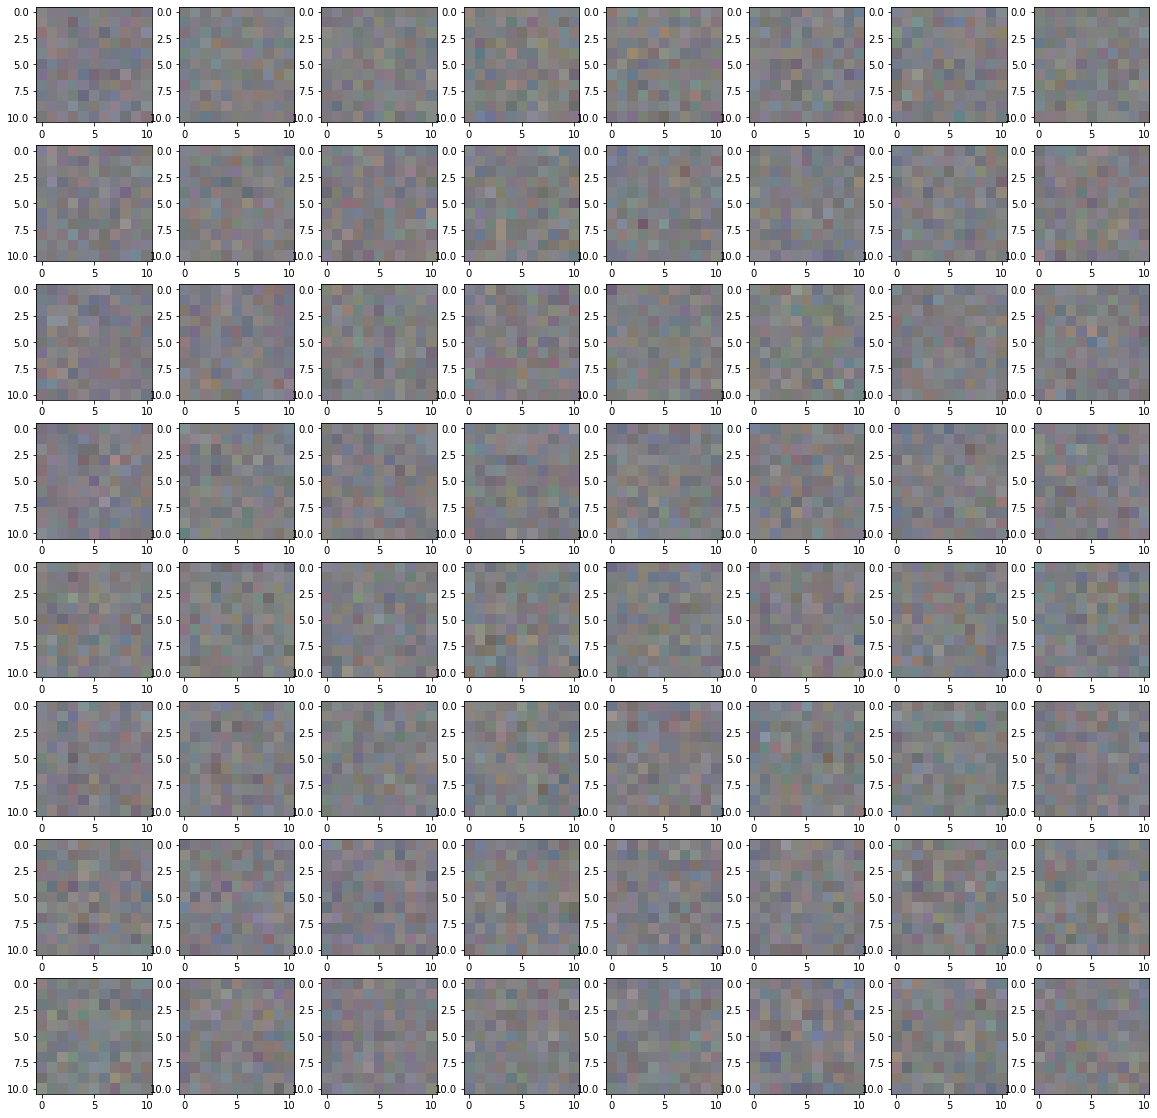

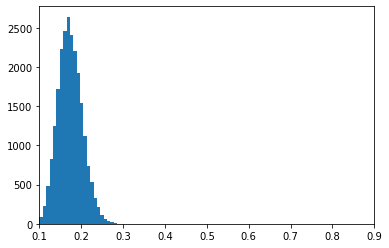

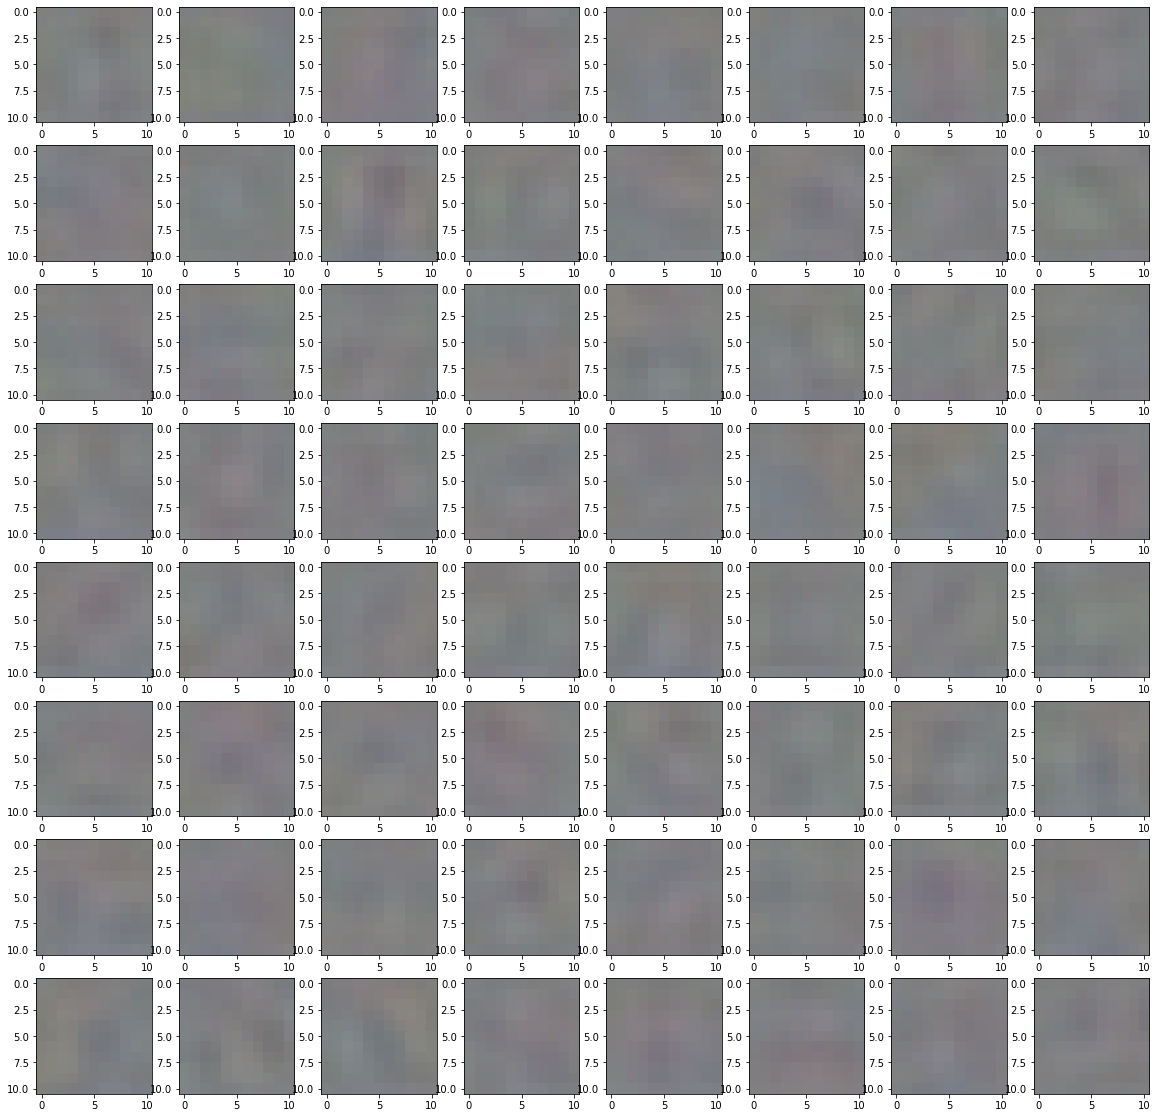

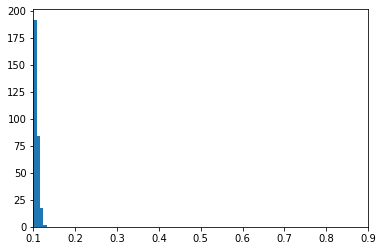

In [72]:
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        for _ in range(64):
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            pars[_].append(v)
    plt.figure(figsize=(20,20))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(8, 8, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds,bins=np.linspace(0.1,0.9,100))
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

# Hold quenched transform fixed and run multiple runs on that transformation

In [ ]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)a

# Polynomial Regression

/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_80_numexamples_50000_is_online_False_rep_1659883579.15472.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_12_numexamples_50000_is_online_False_rep_1659870169.860898.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_8_numexamples_50000_is_online_False_rep_1659876258.581298.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_4_numexamples_50000_is_online_False_rep_1659863364.102298.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_2_numexamples_50000_is_online_False_rep_1659869639.965359.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_12_numexamples_50000_is_online_False_rep_1659863581.638904.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_4_numexamples_50000_is_online_False_rep_1659857422.732516.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_1_numinputs_80_numexamples_50000_is_online_False_rep_1659890764.101892.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_

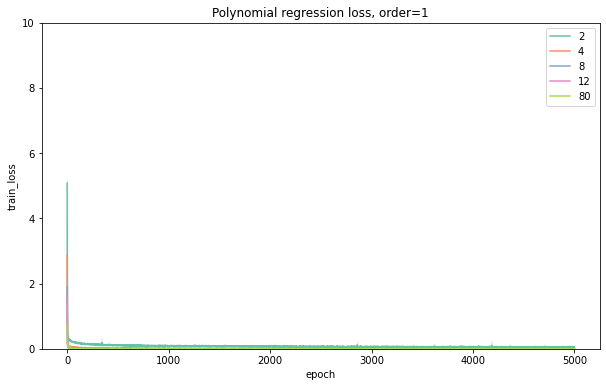

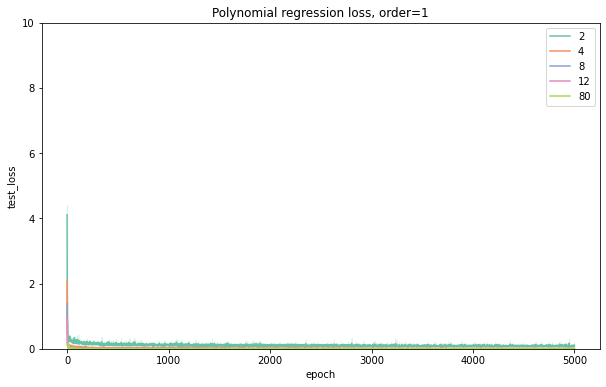

/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1659884296.413174.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_rep_1659889956.726585.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1659870262.520029.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1659863717.686427.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1659857626.699705.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1659870365.547224.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1659857576.313741.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1659870616.080579.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_

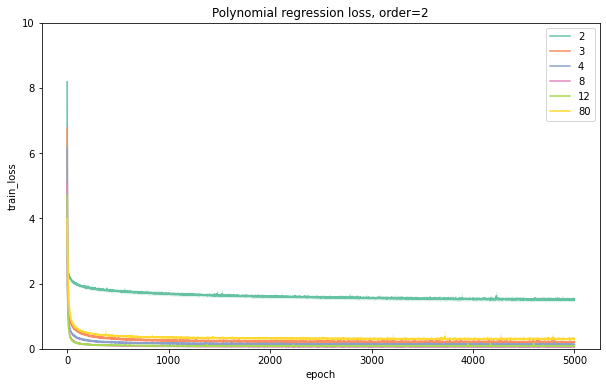

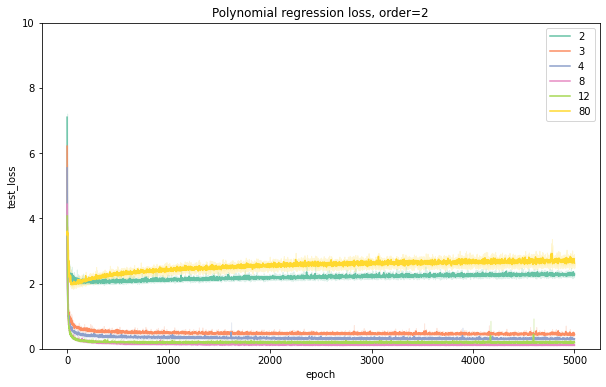

/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1659883585.733308.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1659857626.701026.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1659870525.595475.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1659877286.610197.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_12_numexamples_50000_is_online_False_rep_1659889414.251273.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_12_numexamples_50000_is_online_False_rep_1659890317.029709.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_12_numexamples_50000_is_online_False_rep_1659883501.879984.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1659863970.718226.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_

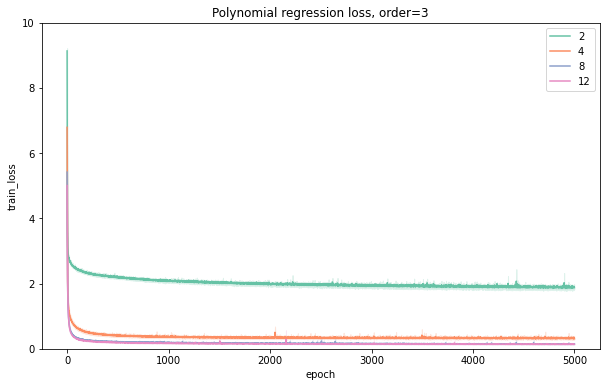

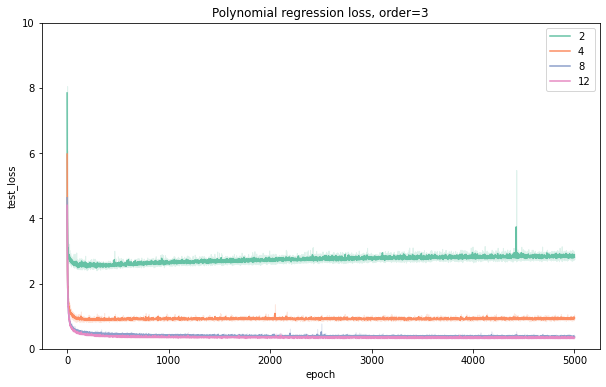

/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_4_numexamples_50000_is_online_False_rep_1659870712.822285.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_80_numexamples_50000_is_online_False_rep_1659884353.822489.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_12_numexamples_50000_is_online_False_rep_1659857648.595494.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_8_numexamples_50000_is_online_False_rep_1659877458.253125.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_12_numexamples_50000_is_online_False_rep_1659864053.685092.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_4_numexamples_50000_is_online_False_rep_1659863975.733571.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_80_numexamples_50000_is_online_False_rep_1659877607.098263.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_5_numinputs_80_numexamples_50000_is_online_False_rep_1659891388.566718.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_orde

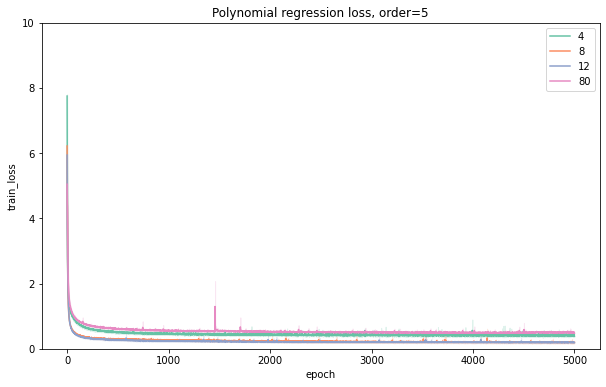

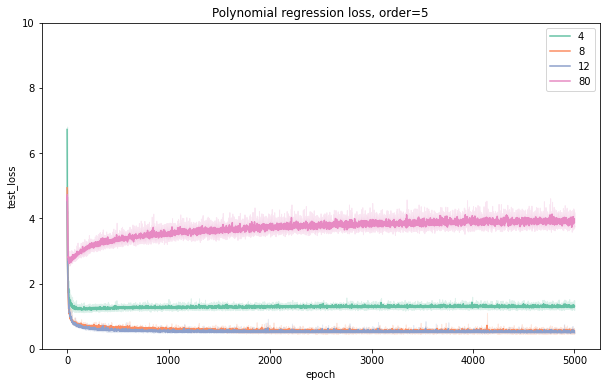

/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_4_numexamples_50000_is_online_False_rep_1659890400.356907.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_80_numexamples_50000_is_online_False_rep_1659871419.26643.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_8_numexamples_50000_is_online_False_rep_1659857673.831742.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_8_numexamples_50000_is_online_False_rep_1659864151.544009.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_2_numexamples_50000_is_online_False_rep_1659857673.639599.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_11_numexamples_50000_is_online_False_rep_1659891287.514931.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_4_numexamples_50000_is_online_False_rep_1659883540.607484.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_order_10_numinputs_2_numexamples_50000_is_online_False_rep_1659863922.282594.pkl
/scratch/gpfs/qanguyen/poly1/mlp_small_

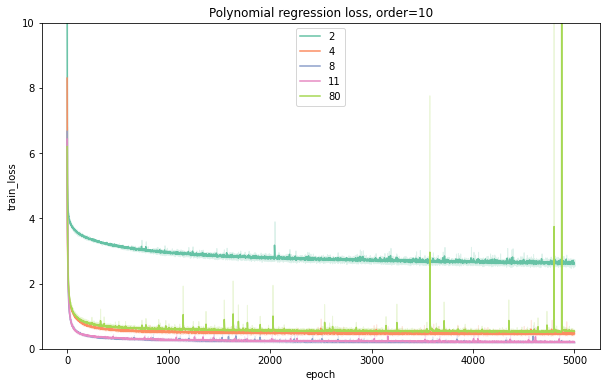

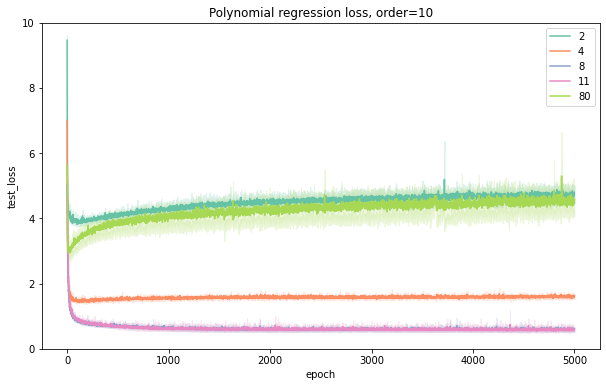

In [4]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    outdir = "/scratch/gpfs/qanguyen/poly1/"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*_is_online_{is_online}_*"):
        print(f)
        record = utils.load_file_pickle(f)
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))

    plt.figure(figsize=(10,6))

    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars)
    plt.legend()
    plt.ylim(0, 10)
    plt.title(title)
    plt.show()
    
    plt.figure(figsize=(10,6))
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars)
    plt.legend()
    plt.ylim(0, 10)
    plt.title(title)
    plt.show()
    
import warnings

get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1")
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3")
get_record(model_name = "mlp_small", order = 5, is_online=False, title = "Polynomial regression loss, order=5")
get_record(model_name = "mlp_small", order = 10, is_online=False, title = "Polynomial regression loss, order=10")

/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_4_random_coefs_True_rep_1659648848.862847.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_2_random_coefs_True_rep_1659648741.519456.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_2_random_coefs_True_rep_1659648641.2803.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_4_random_coefs_True_rep_1659649180.836485.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_4_random_coefs_True_rep_1659648950.056305.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_10_random_coefs_True_rep_1659648757.07573.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_80_random_coefs_True_rep_1659648975.892153.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_80_random_coefs_True_rep_1659649085.263957.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_2_random_coefs_True_rep_1659648537.915438.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_1_numinputs_10_random_coefs_True_rep_1659648652.980364.pkl
/scratch/

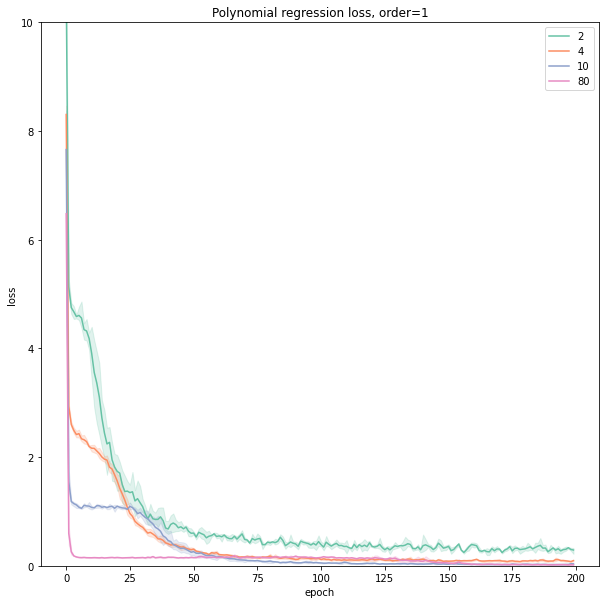

/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_4_random_coefs_True_rep_1659649122.990635.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_6_random_coefs_True_rep_1659648853.941661.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_80_random_coefs_True_rep_1659649376.187932.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_80_random_coefs_True_rep_1659649516.431566.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_10_random_coefs_True_rep_1659648947.885877.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_4_random_coefs_True_rep_1659648988.791214.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_2_random_coefs_True_rep_1659648834.271844.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_6_random_coefs_True_rep_1659648723.852943.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_10_random_coefs_True_rep_1659648790.937798.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_5_numinputs_4_random_coefs_True_rep_1659649257.311512.pkl
/scrat

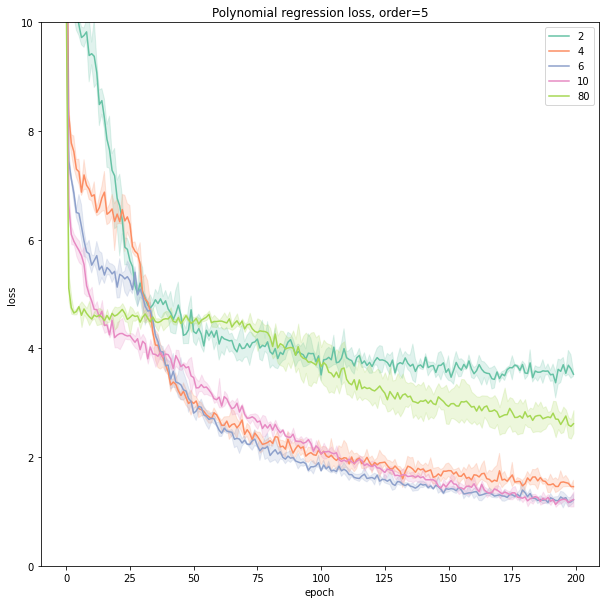

/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_8_random_coefs_True_rep_1659648876.623954.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_80_random_coefs_True_rep_1659649104.123839.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_4_random_coefs_True_rep_1659649404.116059.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_11_random_coefs_True_rep_1659649392.910539.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_80_random_coefs_True_rep_1659649274.23473.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_8_random_coefs_True_rep_1659649222.788866.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_80_random_coefs_True_rep_1659649446.04621.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_2_random_coefs_True_rep_1659649054.258574.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_8_random_coefs_True_rep_1659649051.401305.pkl
/scratch/gpfs/qanguyen/poly/mlp100_order_10_numinputs_2_random_coefs_True_rep_1659649228.628184.pk

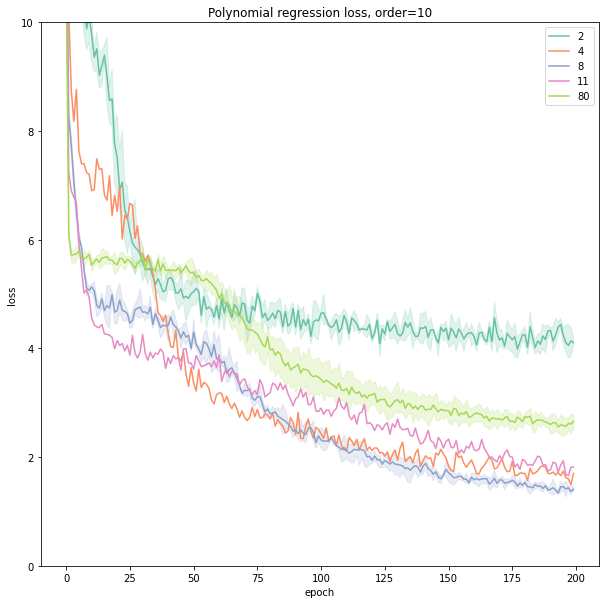

In [24]:
get_record(model_name = "mlp100", order = 1, random_coefs=True, title = "Polynomial regression loss, order=1")
get_record(model_name = "mlp100", order = 5, random_coefs=True, title = "Polynomial regression loss, order=5")
get_record(model_name = "mlp100", order = 10, random_coefs=True, title = "Polynomial regression loss, order=10")

/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_4_random_coefs_True_rep_1659650631.904482.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_4_random_coefs_True_rep_1659650895.915161.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_10_random_coefs_True_rep_1659649582.400203.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_4_random_coefs_True_rep_1659650366.334566.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_2_random_coefs_True_rep_1659649836.619751.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_80_random_coefs_True_rep_1659650693.44129.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_10_random_coefs_True_rep_1659650134.742938.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_2_random_coefs_True_rep_1659649571.352772.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_80_random_coefs_True_rep_1659650416.73603.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_1_numinputs_10_random_coefs_True_rep_1659649861.686429.pkl
/scratc

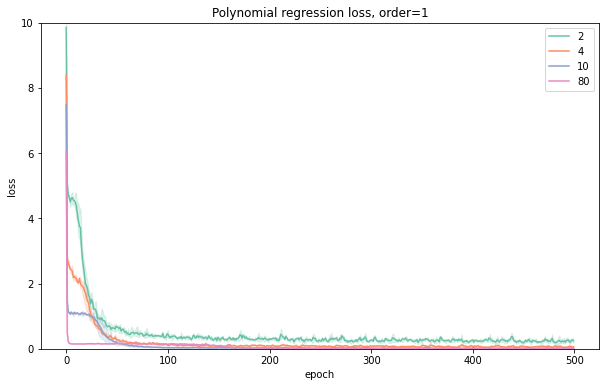

/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_6_random_coefs_True_rep_1659650234.975457.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_2_random_coefs_True_rep_1659650215.277724.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_6_random_coefs_True_rep_1659649926.56638.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_2_random_coefs_True_rep_1659649594.468945.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_10_random_coefs_True_rep_1659650880.880437.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_80_random_coefs_True_rep_1659650347.726268.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_80_random_coefs_True_rep_1659649983.249299.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_2_random_coefs_True_rep_1659649907.31913.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_4_random_coefs_True_rep_1659650842.047277.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_5_numinputs_10_random_coefs_True_rep_1659651216.333462.pkl
/scratch

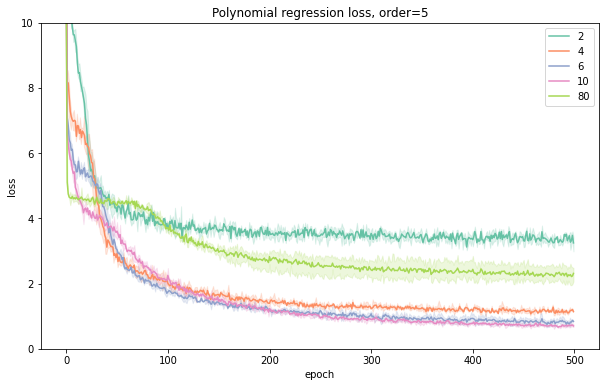

/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_11_random_coefs_True_rep_1659649660.372492.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_11_random_coefs_True_rep_1659650126.212005.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_11_random_coefs_True_rep_1659650583.707861.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_4_random_coefs_True_rep_1659650496.150114.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_4_random_coefs_True_rep_1659649660.578281.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_8_random_coefs_True_rep_1659650917.350134.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_2_random_coefs_True_rep_1659650716.16827.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_8_random_coefs_True_rep_1659651340.152444.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_4_random_coefs_True_rep_1659650077.713272.pkl
/scratch/gpfs/qanguyen/poly/mlp500_order_10_numinputs_2_random_coefs_True_rep_1659651152.189451.pk

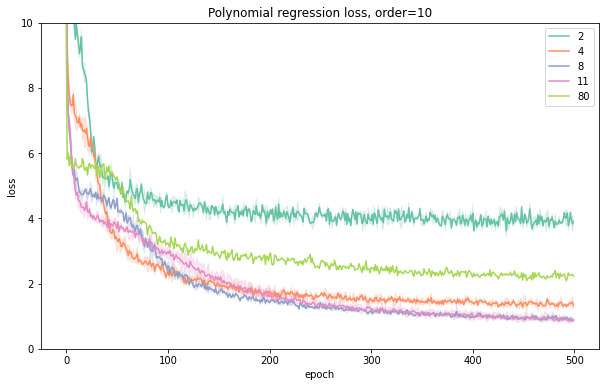

In [30]:
get_record(model_name = "mlp500", order = 1, random_coefs=True, title = "Polynomial regression loss, order=1")
get_record(model_name = "mlp500", order = 5, random_coefs=True, title = "Polynomial regression loss, order=5")
get_record(model_name = "mlp500", order = 10, random_coefs=True, title = "Polynomial regression loss, order=10")